In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.data import DataLoader, Dataset

In [ ]:
if os.getcwd() == '/content':
    os.chdir('/content/drive/Shareddrives/시게열 모델링/분류예측/박준우/data')

In [ ]:
class Act2Vec(nn.Module):
    def __init__(self, 
                 n_classes=None, 
                 n_times=None,
                 output_dim=None, 
                 embedding_dim=None, 
                 hidden_size=None, 
                 num_layers=None,
                 num_nodes=None,
                 dropout=None):
        super(Act2Vec, self).__init__()

        self.n_classes = n_classes
        self.n_times = n_times
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.num_nodes = num_nodes
        self.activation = nn.SiLU()
        self.dropout = dropout
        self.dropout_layer = nn.Dropout(self.dropout)

        self.embed_layers = nn.ModuleList([nn.Embedding(num_embeddings=n_class,
                                                        embedding_dim=self.embedding_dim,
                                                        padding_idx=0) 
                                            for n_class in self.n_classes])
        self.lstm = nn.LSTM(input_size=len(self.n_classes)*self.embedding_dim, 
                            hidden_size=self.hidden_size, 
                            num_layers=self.num_layers,
                            batch_first=True,
                            dropout=self.dropout)
        self.flatten = nn.Flatten()

        self.prev_num_nodes = [self.n_times*self.hidden_size] + self.num_nodes[:-1]
        self.dense_layers = nn.ModuleList([nn.Linear(n1, n2) 
                                            for n1, n2 in zip(self.prev_num_nodes, 
                                                              self.num_nodes)])
        self.output_layer = nn.Linear(self.num_nodes[-1], 
                                      self.output_dim)

    def forward(self, x):
        # embedding 레이어는 정수 텐서 입력을 받음
        # Dataset에서 처리해줄거긴 한데 혹시 모르니 안전빵...
        x = x.type(torch.LongTensor).to(device)

        # output of ith feature's embedding layer.
        embeddeds = [layer(x[:, :, i]) for i, layer in enumerate(self.embed_layers)]
        x = torch.concat(embeddeds, dim=-1)

        # lstm forward
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        x, _ = self.lstm(x, (h0, c0))   # x: (batch, seq_len, hidden_size)

        x = self.flatten(x)
        x = self.dropout_layer(x)

        # Dense layer forward
        for layer in self.dense_layers:
            x = layer(x)
            x = self.activation(x)
            x = self.dropout_layer(x)

        # output
        out = self.output_layer(x)

        return out

    def embed(self, x):
        return [layer(x[:, :, i]) for i, layer in enumerate(self.embed_layers)]

In [ ]:
model = torch.load('A2V.pt')
model

Act2Vec(
  (activation): SiLU()
  (dropout_layer): Dropout(p=0.3, inplace=False)
  (embed_layers): ModuleList(
    (0): Embedding(9, 64, padding_idx=0)
    (1): Embedding(4, 64, padding_idx=0)
    (2): Embedding(7, 64, padding_idx=0)
    (3): Embedding(4, 64, padding_idx=0)
    (4): Embedding(3, 64, padding_idx=0)
    (5): Embedding(7, 64, padding_idx=0)
  )
  (lstm): LSTM(384, 128, num_layers=3, batch_first=True, dropout=0.3)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense_layers): ModuleList(
    (0): Linear(in_features=1280, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (output_layer): Linear(in_features=1024, out_features=9, bias=True)
)

In [ ]:
act = pd.read_csv('제6회 L.POINT Big Data Competition-분석용데이터-01.온라인 행동 정보.csv')
demo = pd.read_csv('제6회 L.POINT Big Data Competition-분석용데이터-03.고객 Demographic 정보.csv')
act = act.sort_values(by=['clnt_id', 'sess_id', 'hit_seq'])
act['hit_pss_tm'] = act.groupby('clnt_id')['hit_pss_tm'].diff().replace({np.nan: 0})
act
act = act.merge(demo, left_on='clnt_id', right_on='clnt_id', how='left')
act
cat_features = ['action_type', 'biz_unit', 'trfc_src', 'dvc_ctg_nm', 'clnt_gender', 'clnt_age']
numeric_features = ['hit_pss_tm', 'tot_pag_view_ct', 'tot_sess_hr_v']
# tokenizing
token = {
'action_type': {'unknown': 0,
                '검색': 1,
                '제품 목록': 2, 
                '제품 세부정보': 3,
                '장바구니 추가': 4,
                '장바구니 삭제': 5,
                '결제 시도': 6,
                '구매 완료': 7,
                '구매 환불': 8},
'biz_unit': {'unknown': 0,
             'A01': 1, 
             'A02': 2, 
             'A03': 3},
'trfc_src': {'unknown': 0, 
             'DIRECT': 1, 
             'PUSH': 2, 
             'PORTAL_1': 3, 
             'WEBSITE': 4, 
             'PORTAL_2': 5,
             'PORTAL_3': 6},
'dvc_ctg_nm': {'unknown': 0,
               'mobile_app': 1,
               'mobile_web': 2,
               'PC': 3},
'clnt_gender': {'unknown': 0,
                'F': 1,
                'M': 2},
'clnt_age': {'unknown': 0,
             '10': 1,
             '20': 2,
             '30': 3,
             '40': 4,
             '50': 5,
             '60': 6,}
}
act['action_type'] = act['action_type'] + 1 # action_type 0: padding 
act['biz_unit'] = act['biz_unit'].replace(token['biz_unit'])
act['trfc_src'] = act['trfc_src'].replace(token['trfc_src'])
act['dvc_ctg_nm'] = act['dvc_ctg_nm'].replace(np.nan, 'unknown').replace(token['dvc_ctg_nm'])
act['clnt_gender'] = act['clnt_gender'].replace(token['clnt_gender'])
act['clnt_age'] = act['clnt_age'].replace(token['clnt_age'])
# 'action_type', 'hit_seq', 'biz_unit' 는 패딩idx 0의 값이 없지만, 
# 있을거라고 가정해서 범주 개수를 1개 늘려줘야함
n_classes = [9, 4, 7, 4, 3, 7]
# n_times 기간의 action_type 시퀀스를 이용해
# 다음 predict_period 스텝의 action_type을 예측하는 task로
# 따라서 최소 n_times + predict_period 개의 데이터가 있어야 함

n_times = 10
predict_period = 1
X, y = [], []
def make_seq(x, target_col='action_type'):
    # 최소 n_times + predict_period 개의 데이터가 있는 것에 한해서,
    if len(x) >= n_times + predict_period:
        # with sliding window trick
        I_src = np.arange(n_times).reshape(1, -1)
        S_src = np.arange(len(x)-n_times-predict_period+1).reshape(-1, 1)
        src = x.values[I_src+S_src]

        I_trg = np.arange(predict_period).reshape(1, -1)
        S_trg = np.arange(n_times, len(x)).reshape(-1, 1)
        trg = x[target_col].values[I_trg+S_trg]

        X.append(src)
        y.append(trg)

# sess_id 별로 시퀀스 생성 -> 10초만에 끝!
(act[['clnt_id', 'sess_id']+cat_features+numeric_features]
 .groupby(['clnt_id', 'sess_id'])
 .apply(lambda x: make_seq(x)))

X = np.concatenate(X, axis=0)[:, :, 2:] # index 0,1 of last dim is clnt_id, sess_id
y = np.concatenate(y, axis=0)
X.shape, y.shape

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7, 
                                                    random_state=96,
                                                    stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                train_size=0.5, 
                                                random_state=96,
                                                stratify=y_test)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


device(type='cuda', index=0)

In [ ]:
class ActDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.LongTensor(x)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [ ]:
test_ds = ActDataset(X_test, y_test)

In [ ]:
BATCH_SIZE = 1024
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [ ]:
from tqdm import tqdm

In [ ]:
model.eval()

y_pred = []
with torch.no_grad():
    for data, label in tqdm(test_dl):
        outputs = model(data.to(device))
        _, predicted = torch.max(outputs.data, 1)
        y_pred.append(predicted)
y_pred

100%|██████████| 227/227 [00:02<00:00, 93.04it/s] 


[tensor([5, 6, 3,  ..., 2, 4, 2], device='cuda:0'),
 tensor([1, 3, 6,  ..., 3, 3, 6], device='cuda:0'),
 tensor([4, 6, 6,  ..., 4, 1, 6], device='cuda:0'),
 tensor([1, 3, 6,  ..., 6, 6, 4], device='cuda:0'),
 tensor([4, 6, 6,  ..., 4, 1, 6], device='cuda:0'),
 tensor([1, 6, 2,  ..., 5, 1, 6], device='cuda:0'),
 tensor([2, 2, 6,  ..., 6, 3, 6], device='cuda:0'),
 tensor([3, 6, 1,  ..., 2, 4, 6], device='cuda:0'),
 tensor([3, 6, 4,  ..., 5, 4, 1], device='cuda:0'),
 tensor([6, 4, 6,  ..., 5, 3, 6], device='cuda:0'),
 tensor([4, 1, 6,  ..., 6, 5, 1], device='cuda:0'),
 tensor([1, 6, 4,  ..., 5, 1, 6], device='cuda:0'),
 tensor([2, 6, 4,  ..., 4, 3, 4], device='cuda:0'),
 tensor([4, 6, 6,  ..., 6, 6, 6], device='cuda:0'),
 tensor([6, 6, 1,  ..., 4, 3, 1], device='cuda:0'),
 tensor([6, 6, 1,  ..., 3, 4, 6], device='cuda:0'),
 tensor([1, 3, 4,  ..., 4, 1, 4], device='cuda:0'),
 tensor([6, 4, 3,  ..., 6, 3, 3], device='cuda:0'),
 tensor([3, 4, 1,  ..., 6, 3, 3], device='cuda:0'),
 tensor([6, 

In [ ]:
y_pred = torch.cat(y_pred)
y_pred.size()

torch.Size([232433])

In [ ]:
y_pred = y_pred.cpu().numpy()
y_pred = y_pred - 1
np.save('y_pred.npy', y_pred)
y_pred.shape

(232433,)

In [ ]:
np.unique(y_pred)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
y_test = np.squeeze(y_test)
y_test = y_test - 1
y_test.shape

(232433,)

In [ ]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [ ]:
f1 = f1_score(y_test, y_pred, average='weighted')
f1

0.6100383820373279

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[23398,  1952,   677,  5898,  1291,  6471,     7,     1],
       [ 3816,  7614,  1803,  3712,  1215,  4381,     5,     1],
       [ 1748,  1327, 25528,  2418,   229,  2490,    49,     3],
       [ 9637,  1642,   381, 24710,   647,  4777,     8,     0],
       [  297,   546,   140,   586,  7103,  7953,     0,     0],
       [ 5143,  1308,  1193,  6299,  3838, 55358,    65,     1],
       [   79,    80,   239,    21,     2,  3900,   184,     2],
       [    5,    22,   100,     8,     0,    69,     0,    56]])

In [ ]:
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'white'

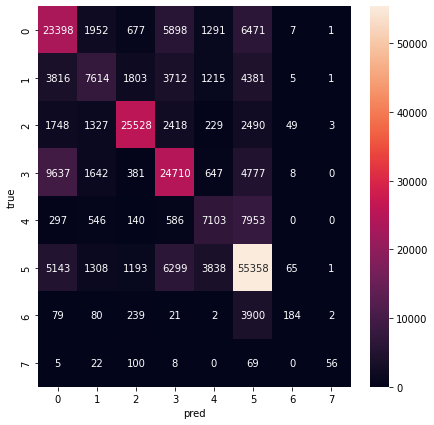

In [ ]:
import seaborn as sns 

plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('pred')
plt.ylabel('true')
plt.show()

In [ ]:
_, d = np.unique(y_test, return_counts=True)
np.around(d / d.sum(), 4)

array([0.1708, 0.097 , 0.1454, 0.1798, 0.0715, 0.315 , 0.0194, 0.0011])

In [ ]:
y_test

array([4, 1, 6, ..., 0, 5, 0])

(array([39695., 22547., 33792., 41802., 16625., 73205.,  4767.]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 <a list of 7 Patch objects>)

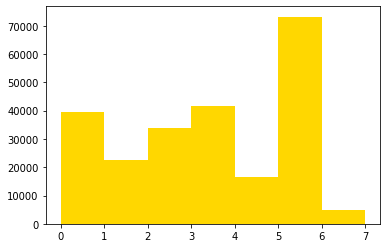

In [ ]:
plt.hist(y_test, range(8), color='gold')

(array([15565.,  7813.,   492.]),
 array([1, 2, 3, 4]),
 <a list of 3 Patch objects>)

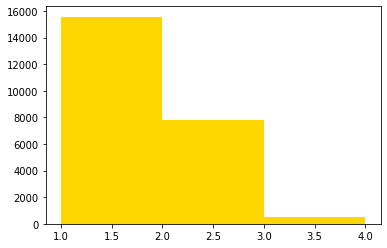

In [ ]:
plt.hist(np.repeat([1,2,3], [15565, 7813, 492]), [1,2,3,4], color='gold')

(array([  233.,  6296., 17341.]),
 array([1, 2, 3, 4]),
 <a list of 3 Patch objects>)

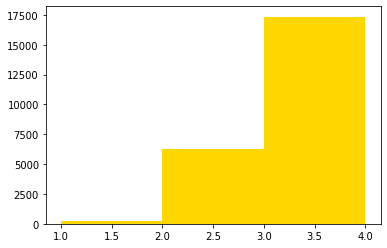

In [ ]:
plt.hist(np.repeat([1,2,3], [233, 6296, 17341]), [1,2,3,4], color='gold')